# Estimators and parameters for applying TE to empirical data -- Sleep Apnoea

## A. Active information storage in breath rate

We'll begin our modelling process by accounting for the past of the breath rate time series, using active information storage. Recall that the AIS represents the first step in an information regression of modelling the dynamic updates of the target.

1. Open the AIS AutoAnalyser, selecting the `Kraskov (KSG)` estimator, and the `SFI-heartRate_breathVol_bloodOx-extract.txt` data set.
2. Change the variable column to 1 (breath rate).
3. Recall from our analysis of statistical significance in Module 7 that controlling for autocorrelation in samples here is quite important. So set the property `DYN_CORR_EXCL` to 15 (which was the maximum of the autocorrelation lengths we identified for the heart and breath rates.
4. Let's ask JIDT to set embedding parameters for the breath rate automatically for us, allowing long dimension and lag since we know that these are complex time series:
    1. Set `AUTO_EMBED_METHOD` to `MAX_CORR_AIS` to embed both source and target.
    2. Set `AUTO_EMBED_METHOD_K_SEARCH_MAX` to `10` to search for an embedding length up to 10.
    3. Set `AUTO_EMBED_METHOD_TAU_SEARCH_MAX` to `10` to search for an embedding delay up to 10 (allowing a longer lag than usual since the time series are complex)
5. Press `Generate code and compute`:
    * Inspect the resulting embedding parameters as displayed in the `k_HISTORY` and `TAU` values in the properties section.
    * You should see a result around 0.59 nats, which is reasonably large (as is usually the case for modelling information storage for continuous valued processes sampled in time, since they are usually slowly varying).
6. Copy the code into the following code cells and run them.

In [1]:
# Paste import and JVM startup lines here:

from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/home/joseph/JIDT/infodynamics-dist-1.6.1/demos/python")
import readFloatsFile

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/home/joseph/JIDT/infodynamics-dist-1.6.1/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

In [2]:
# Paste analysis code here:

# 0. Load/prepare the data:
dataRaw = readFloatsFile.readFloatsFile("/home/joseph/JIDT/infodynamics-dist-1.6.1/demos/data/SFI-heartRate_breathVol_bloodOx-extract.txt")
# As numpy array:
data = numpy.array(dataRaw)
variable = JArray(JDouble, 1)(data[:,1].tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").ActiveInfoStorageCalculatorKraskov
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("AUTO_EMBED_METHOD", "MAX_CORR_AIS")
calc.setProperty("AUTO_EMBED_K_SEARCH_MAX", "10")
calc.setProperty("AUTO_EMBED_TAU_SEARCH_MAX", "10")
calc.setProperty("DYN_CORR_EXCL", "15")
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(variable)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

print("AIS_Kraskov (KSG)(col_1) = %.4f nats" %\
    (result))

AIS_Kraskov (KSG)(col_1) = 0.5848 nats


  The following code cell plots the breath rate versus time (like the example on the tutorial page) -- run this code cell:

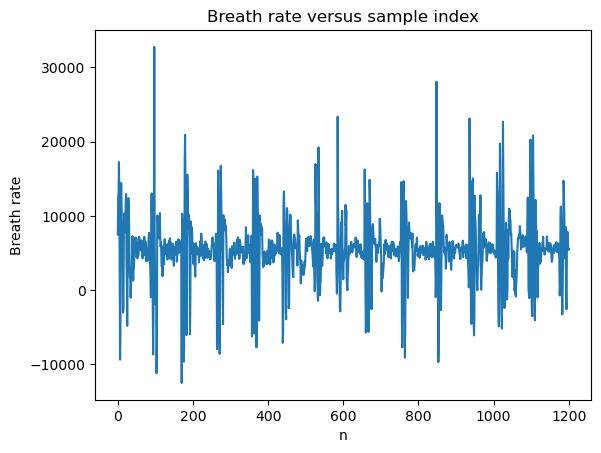

In [3]:
# Plot the breath rate versus sample index:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(variable)
plt.title('Breath rate versus sample index')
plt.xlabel('n')
plt.ylabel('Breath rate')
plt.show();

The next code cell makes an additional plot -- inspect the code in the cell below:
  * The first two lines of second code cell show an example of how to read out an automatically determined embedding parameter (or any other property for that matter) in code. This may be useful e.g. if you want to set the determined embedding for another calculation.
  * The subsequent lines compute and then plot the local AIS values against the corresponding next value of the breath rate, so that we can see where in the dynamics the past is most strongly informative. (See sample plot on the tutorial webpage).

7. Run this next code cell, and examine the plot -- what can you see about how the AIS relates to the dynamics? I.e. for which values of the breath rate do we see extreme values of the AIS?

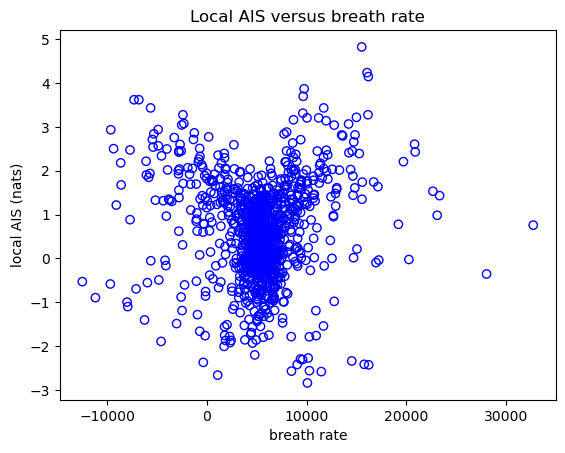

In [4]:
# Now make an additional plot (explained in the text below)
k_str = calc.getProperty('k_HISTORY'); # Returns a string for the property name: useful where setting the property again
k = int(k_str); # Converts the string to an integer, useful if we need to use it in later code
localAIS = calc.computeLocalOfPreviousObservations();
plt.figure();
plt.scatter(variable, localAIS, marker='o', color='blue', facecolors='none');
plt.xlabel('breath rate');
plt.ylabel('local AIS (nats)');
plt.title('Local AIS versus breath rate');

8. There is not a one-to-one mapping between breath rate and AIS, since the AIS depends on the past values of breath rate as well. To try to get further insights, run the following code cell:

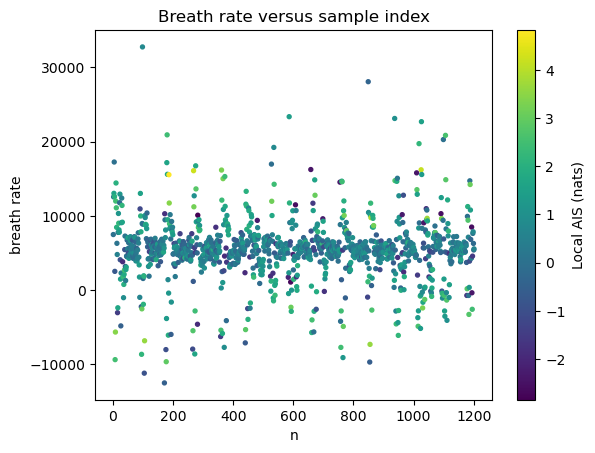

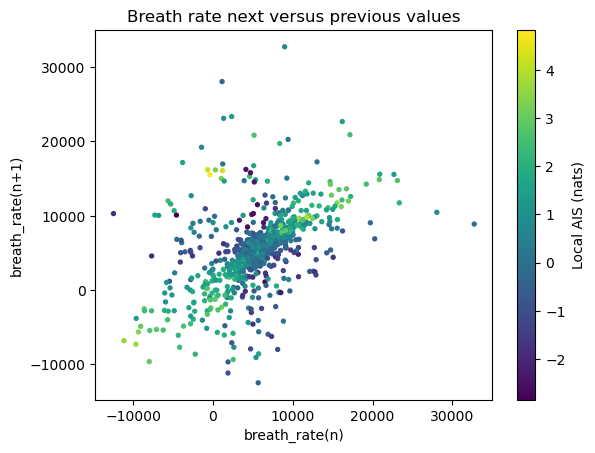

In [5]:
plt.figure();
plt.scatter(range(1,variable.length+1), variable, c=localAIS, marker='o', facecolors='none', s=8);
plt.xlabel('n'); plt.ylabel('breath rate'); plt.colorbar(label='Local AIS (nats)');
plt.title('Breath rate versus sample index');

plt.figure();
plt.scatter(variable[:-1], variable[1:], c=localAIS[1:], marker='o', facecolors='none', s=8);
plt.xlabel('breath_rate(n)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local AIS (nats)');
plt.title('Breath rate next versus previous values');

  The code in the cell above plots the dynamics in two different ways, highlighting each point in the time series according to their local AIS value. On the first, you could zoom in around an apnoea event to inspect where the higher and lower AIS events occur. The second plot may make this more clear for you: certainly the larger AIS values occur at more extreme breath rates, but compare the AIS values for these extreme breath rates where the previous breath rates were or were not already extreme:
  * For the breath rates being in the stable range, what sorts of AIS values do we have? how could we interpret that?
  * Which parts of the breath rate dynamics have most potential for information to be added from other source variables?

Sample solution plots are available on the tutorial webpage.

## B. Transfer entropy from heart rate to breath rate

The next step in our information regression of modelling the dynamic updates of the target is to include contributions from an information source: we will examine the information flow from heart rate to breath here:
1. Open the TE AutoAnalyser, selecting the `Kraskov (KSG)` estimator, and the `SFI-heartRate_breathVol_bloodOx-extract.txt` data set.
2. Leave the source column at 0 (heart rate) and destination column at 1 (breath rate).
3. Check the `Add stat. signif.?` button, as we wish to check the statistical significance of our measurements.
4. Set `DYN_CORR_EXCL` to 15 as above.
5. Leave all of the other parameters as defaults for now, to test that we can run a calculation - press `Generate code and compute`. Hmmm, the result of around 0.0112 bits is much smaller than we measured with MI before and the p-value doesn't look significant. But we haven't properly set the embedding parameters, so let's not draw a hasty conclusion.
6. Let's ask JIDT to set embedding parameters for both the heart rate and breath rate automatically for us. We already computed these for the breath rate using AIS, and in code we could read these out as above and include them here; but let's calculate again to confirm we get the same result. We know that both are complex time series, and there are potentially multiple past values of the source contributing to the target so we will embed the source as well as target here:
    1. Set `AUTO_EMBED_METHOD` to `MAX_CORR_AIS` to embed both source and target.
    2. Set `AUTO_EMBED_METHOD_K_SEARCH_MAX` to 10 to search for an embedding length up to 10.
    3. Set `AUTO_EMBED_METHOD_TAU_SEARCH_MAX` to 10 to search for an embedding delay up to 10 (allowing a longer lag than usual since the time series are complex)
7. Press `Generate code and compute`:
    * Check that the embedding parameters for the breath rate (the target) are the same as determined via the AIS. Note the embedding parameters determined for the heart rate as source.
    * Now inspect the value of TE. Ok... that value looks very small and is certainly not significant. Perhaps the past history of the breath rate via AIS is accounting for everything that the heart rate could tell us about the breath?
8. Recall however from our previous investigation that we observed a significant MI relationship over lags of 6-12 time steps from the heart rate to breath. Let's compute TE again allowing for such lags. This time - since JIDT has already worked out the embedding lengths - we'll supply the embedding parameters ourselves, and expand the code template to check the TE over various lags. Copy the code generated by the AutoAnalyser into the next code cell, and adjust as follows:
    * Change the `DELAY` property to a non-default value, e.g. 2, so that it gets included in our template code.
    * Uncheck `Compute result?` then press `Generate code`
    * Copy the code in the Python tab and paste into the code cell below.
    * Notice that the code has set the optimised embedding parameters to their non-default values (from our calculation before changing the delay), but also still sets up the parameters for auto-embedding. Let's delete the auto-embedding parameters so that it just uses the values we already determined: delete the lines which set `AUTO_EMBED_METHOD`, `AUTO_EMBED_METHOD_K_SEARCH_MAX` and `AUTO_EMBED_METHOD_TAU_SEARCH_MAX`
    * Run the code in the cell below once to make sure that it computes a TE with the new source-target lag value that you set.
    * Next, add a for-loop, `for delay in range(1,21):` around the lines beginning with setting the `DELAY` property and through to the end of the code. (We could leave the statistical significance calculation out, we're only really interested in it's value for the TE at the largest delay, but let's just leave it there).
    * Change the property value supplied for `DELAY` to `str(delay)`.
    * Change the `print` statement to include the delay in what is printed out
    * Run the code, and observe how the TE changes with the source-target delay.

In [6]:
# Paste the generated code here -- you can skip the import and JVM startup lines and just paste the analysis code:

# 0. Load/prepare the data:
dataRaw = readFloatsFile.readFloatsFile("/home/joseph/JIDT/infodynamics-dist-1.6.1/demos/data/SFI-heartRate_breathVol_bloodOx-extract.txt")
# As numpy array:
data = numpy.array(dataRaw)
source = JArray(JDouble, 1)(data[:,0].tolist())
destination = JArray(JDouble, 1)(data[:,1].tolist())

maxDelay = 20;
results = numpy.zeros(maxDelay)

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("k_HISTORY", "2")
calc.setProperty("l_HISTORY", "2")
for delay in range(1,maxDelay+1):
    calc.setProperty("DELAY", str(delay))
    calc.setProperty("DYN_CORR_EXCL", "15")
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(source, destination)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    results[delay-1] = result;
    # 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
    measDist = calc.computeSignificance(100)
    
    print("TE_Kraskov (KSG)(delay %d) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
        (delay, result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, 100))


TE_Kraskov (KSG)(delay 1) = -0.0037 nats (null: -0.0013 +/- 0.0108 std dev.; p(surrogate > measured)=0.59000 from 100 surrogates)
TE_Kraskov (KSG)(delay 2) = -0.0118 nats (null: -0.0019 +/- 0.0108 std dev.; p(surrogate > measured)=0.84000 from 100 surrogates)
TE_Kraskov (KSG)(delay 3) = 0.0089 nats (null: -0.0033 +/- 0.0119 std dev.; p(surrogate > measured)=0.15000 from 100 surrogates)
TE_Kraskov (KSG)(delay 4) = 0.0253 nats (null: -0.0025 +/- 0.0117 std dev.; p(surrogate > measured)=0.01000 from 100 surrogates)
TE_Kraskov (KSG)(delay 5) = 0.0254 nats (null: 0.0001 +/- 0.0119 std dev.; p(surrogate > measured)=0.01000 from 100 surrogates)
TE_Kraskov (KSG)(delay 6) = 0.0546 nats (null: -0.0011 +/- 0.0125 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
TE_Kraskov (KSG)(delay 7) = 0.0380 nats (null: -0.0015 +/- 0.0122 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
TE_Kraskov (KSG)(delay 8) = 0.0400 nats (null: -0.0038 +/- 0.0113 std dev.; p(surrogate > measur

9. Plot the TE versus delay for good measure. You will need to store each result in the for loop above in an array `results` and then plot them against the delay in the code block below (sample plot shown on the tutorial website). Consider:
    * Which source-target delay do you think we should use in our best model of the dynamics of the breath rate? So which delay, and therefore what value of TE would we attribute to the heart rate - breath rate interaction?
    * Is the p-value for this TE statistically significant against $\alpha=0.05$? Given that we evaluated TEs for 20 potential source-target delays, how many such TEs might we expect to appear statistically significant just by chance if there was actually no relationship? We will discuss family-wise error correction to handle this in our next module.

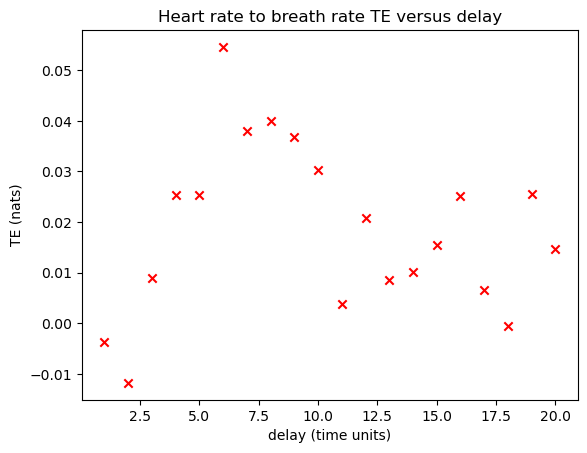

In [7]:
# Add code to plot the TE versus delay here

plt.figure();
plt.scatter(range(1,maxDelay+1), results, marker='x', color='red');
plt.xlabel('delay (time units)');
plt.ylabel('TE (nats)');
plt.title('Heart rate to breath rate TE versus delay');

10. Next, we want to check which parts of the breath rate dynamics the heart rate is adding information to:
    * We will need to re-run the TE calculation for the optimal delay. Copy the lines of code within the for loop above (except for the stat significance check and `print` line) and paste them in again in the code cell below. Set the variable `delay` to the optimal value you determined before the relevant property is set in these new code lines. And don't overwrite the stored values in `results`.
    * Add the following line to compute the local TE values:
      ```python
      localTEs = calc.computeLocalOfPreviousObservations();
      ```
    * Run the code cell so that the local TE values are ready to plot and examine

In [8]:
# Paste and adapt the lines to re-run the TE calculation for the optimal delay here:

# Pull out the optimal delay (we know this to be 6, but this is how to do it automatically in code):
delay = numpy.argmax(results) + 1; # Need to add one to the index here
print('Optimal delay was %d' % delay)

calc.setProperty("DELAY", str(delay))
calc.setProperty("DYN_CORR_EXCL", "15")
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

# Compute the local TE values:
localTEs = calc.computeLocalOfPreviousObservations();

Optimal delay was 6


  * Then we will plot the local TE values against the heart and breath rates in multiple ways to examine where the strong information flows occur. First, let's plot the breath rate transitions (which we examined for AIS) coloured now by TE -- examine the plot code in the following cell (in particular how we plot the local TE for the breath rate at time `n+1` for the breath rate transition from time `n` to time `n+1`) and then run it:

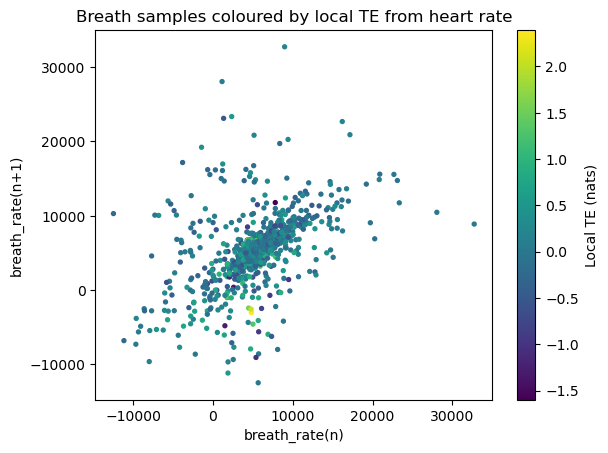

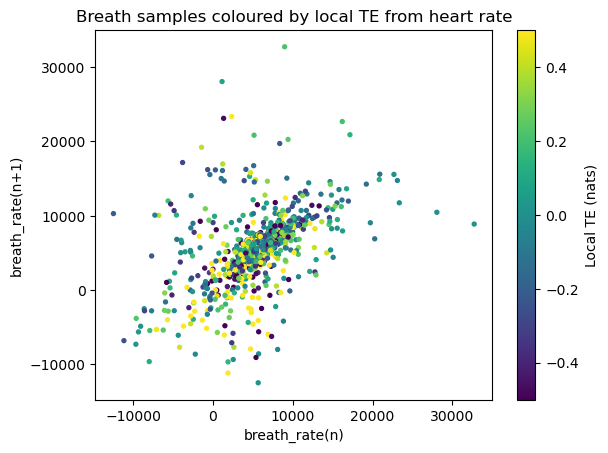

In [9]:
# First let's colour the transitions in breath rate with the TE values
plt.figure();
plt.scatter(destination[delay-1:-1], destination[delay:], c=localTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('breath_rate(n)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local TE (nats)');
plt.title('Breath samples coloured by local TE from heart rate');

# Make a second plot where we highlight the values outside the central range:
plt.figure();
plt.scatter(destination[delay-1:-1], destination[delay:], c=localTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('breath_rate(n)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local TE (nats)');
plt.title('Breath samples coloured by local TE from heart rate');
plt.clim(-0.5,0.5); # Can use this to highlight values out of the central range

  This plot is more difficult to interpret than the similar plot for AIS we looked at before. You should be able to identify though certain parts of the dynamics where the AIS was not particularly strong where the heart rate is able to add significant information. To gain further insights, instead of plotting the raw TE values, alter the colorbar so that values outside of the central range get extreme colours (e.g. `plt.clim(-0.5,0.5);`). Can you identify general aspects of the dynamics where the source usefully adds information here?
  * Next, we'll plot the relationship of previous heart rate to (lagged) breath rate coloured by TE -- inspect and run the following code:

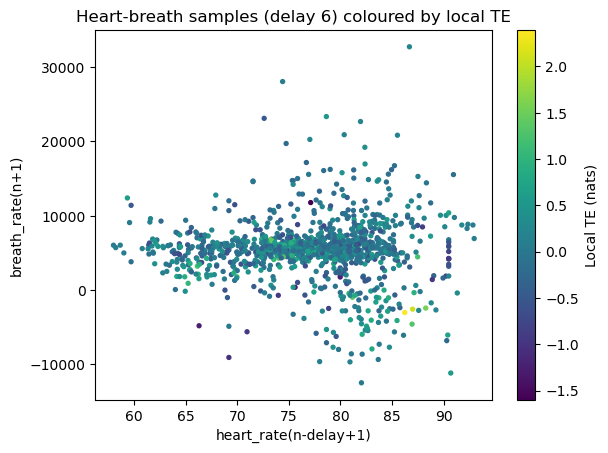

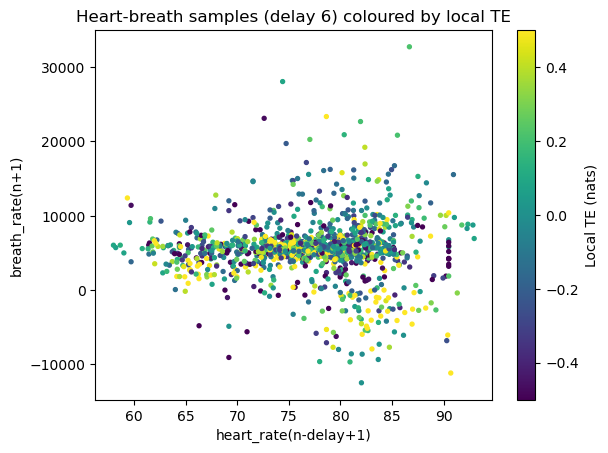

In [10]:
# Next let's make a scatter plot showing the heart rate values:
plt.figure();
plt.scatter(source[:-delay], destination[delay:], c=localTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('heart_rate(n-delay+1)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local TE (nats)');
plt.title('Heart-breath samples (delay %d) coloured by local TE' % delay);

# Make a second plot where we highlight the values outside the central range:
plt.figure();
plt.scatter(source[:-delay], destination[delay:], c=localTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('heart_rate(n-delay+1)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local TE (nats)');
plt.title('Heart-breath samples (delay %d) coloured by local TE' % delay);
plt.clim(-0.5,0.5); # Can use this to highlight values out of the central range

  Again, it's little more tricky to interpret here, but it can be helped e.g. by altering the colorbar as before (e.g. `plt.clim(-0.5,0.5);`). Can you identify general aspects of the dynamics where the source usefully adds information here?

Sample solution plots are available on the tutorial webpage.

## C. Transfer entropy from blood oxygen concentration to breath rate

1. The data set also holds a blood oxygen concentration in the third column. Let's plot it, check its autocorrelation, and also plot it next to the heart and breath rates:

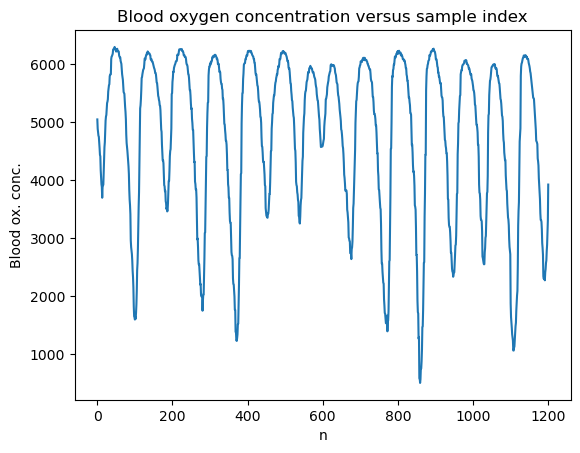

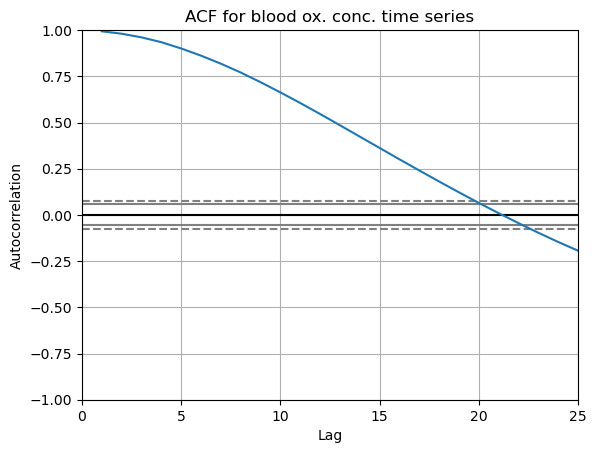

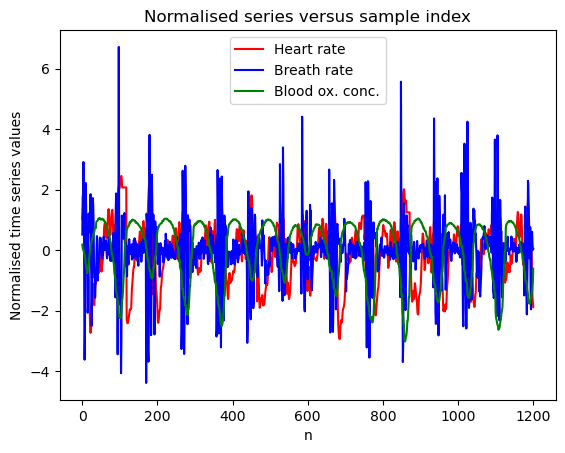

In [11]:
# Plot the blood oxygen concentration time series
plt.figure(); plt.plot(data[:,2]); plt.xlabel('n'); plt.ylabel('Blood ox. conc.');
plt.title('Blood oxygen concentration versus sample index');
plt.show()
# For the autocorrelation we will use the pandas library:
import pandas
pandas.plotting.autocorrelation_plot(data[:,2])
plt.title('ACF for blood ox. conc. time series');
plt.xlim([0,25])
# And finally we plot it with the heart and breath rates
normedData = (data - data.mean(axis=0)) / data.std(axis=0); # Normalise to make the time series easier to compare
plt.figure();
plt.plot(normedData[:,0], color='red', label='Heart rate');
plt.plot(normedData[:,1], color='blue', label='Breath rate');
plt.plot(normedData[:,2], color='green', label='Blood ox. conc.');
plt.xlabel('n'); plt.ylabel('Normalised time series values');
plt.legend()
plt.title('Normalised series versus sample index');

  We can see in the plots that this variable also shows peaks and troughs, with more smooth dynamics, and the troughs coinciding roughly with the apnoea events. It seems that the blood oxygen concentration falls off before the heart rate rises and then the breath rate rises. But can the blood oxygen concentration explain all of what the heart rate adds about the breath rate, does the heart rate add more information, or does the breath rate add other information? We will investigate with the **conditional transfer entropy**.

2. First, let's check the embedding parameters for the blood oxygen concentration. Go back to the TE AutoAnalyser as we were using in the previous activity and:
    * Make sure we're still set up for the `Kraskov (KSG) estimator`, and the `SFI-heartRate_breathVol_bloodOx-extract.txt` data set.
    * Change the source column to 2 (3rd column, but we use Java zero-based indexing in the AutoAnalyser)
    * Change `DYN_CORR_EXCL` to 21 due to the longer autocorrelation we have seen on the blood oxygen concentration variable.
    * Leave the autoembedding set up as before (e.g. with `AUTO_EMBED_METHOD` to `MAX_CORR_AIS` etc.)
    * Run a calculation here (you may need to check `Compute Result?` again) -- we just want to see the embedding that is calculated for the blood oxygen time series. Observe the embedding parameters computed in `l_HISTORY` and `l_TAU`. We're not interested in the result, because we have not optimised the source-target lag here.
    * Press `Generate code and Compute` a second time so that the new embedding is added to the properties in the generated code.
3. Now we need to compute the optimal lag. Make a copy of your code from the TE investigation of heart$\rightarrow$breath rate interaction in the activity above (copy _all_ the code cells in activity B above, in order, into the code cell below). We are going to alter it to now show the TE from the blood oxygenation:
    * Change the source variable to load column 2 of the data instead of column 0.
    * From your AutoAnalyser, copy the code to set the parameters `l_HISTORY` and `l_TAU` and paste these over the top of where the properties for `l_HISTORY` and potentially `l_TAU` are first set early in the code below.
    * Change the value set for `DYN_CORR_EXCL` to `21` (this will be in two places in your code potentially)
    * Change any references to heart rate in your comments or figure captions to blood oxygen.
    * Note that after the for loop, the delay may have been hard-coded to the value we found to be optimal for the heart rate. You can either run once to determine the optimal value for our new source, then go back and set it properly; or use `delay = numpy.argmax(results) + 1;` to automatically set it (if you didn't do that already).

TE_Kraskov (KSG)(delay 1) = 0.0360 nats (null: -0.0037 +/- 0.0139 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
TE_Kraskov (KSG)(delay 2) = 0.0211 nats (null: -0.0040 +/- 0.0115 std dev.; p(surrogate > measured)=0.03000 from 100 surrogates)
TE_Kraskov (KSG)(delay 3) = 0.0306 nats (null: -0.0006 +/- 0.0119 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
TE_Kraskov (KSG)(delay 4) = 0.0320 nats (null: -0.0015 +/- 0.0130 std dev.; p(surrogate > measured)=0.01000 from 100 surrogates)
TE_Kraskov (KSG)(delay 5) = 0.0346 nats (null: -0.0026 +/- 0.0108 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
TE_Kraskov (KSG)(delay 6) = 0.0256 nats (null: -0.0023 +/- 0.0108 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
TE_Kraskov (KSG)(delay 7) = 0.0265 nats (null: -0.0029 +/- 0.0123 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
TE_Kraskov (KSG)(delay 8) = 0.0265 nats (null: -0.0021 +/- 0.0119 std dev.; p(surrogate > measure

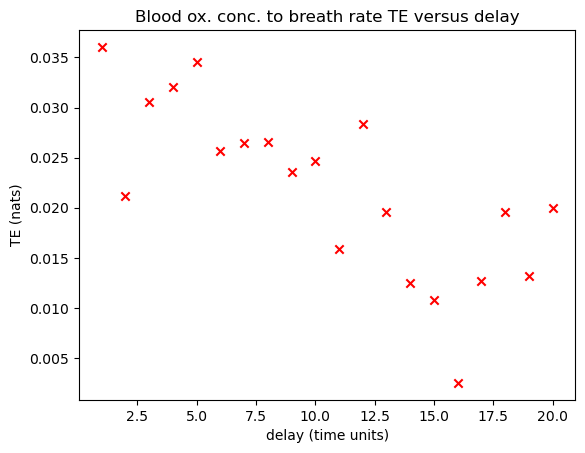

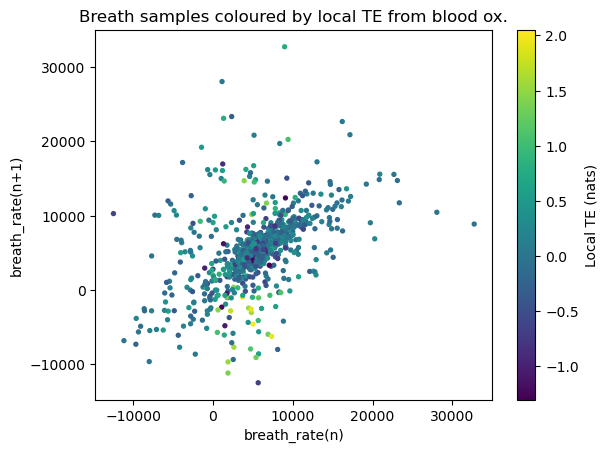

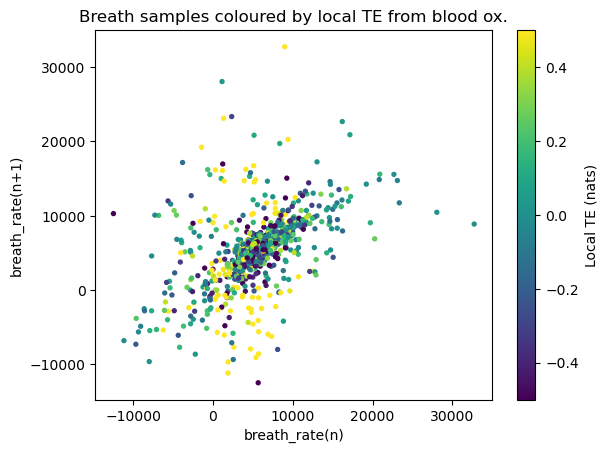

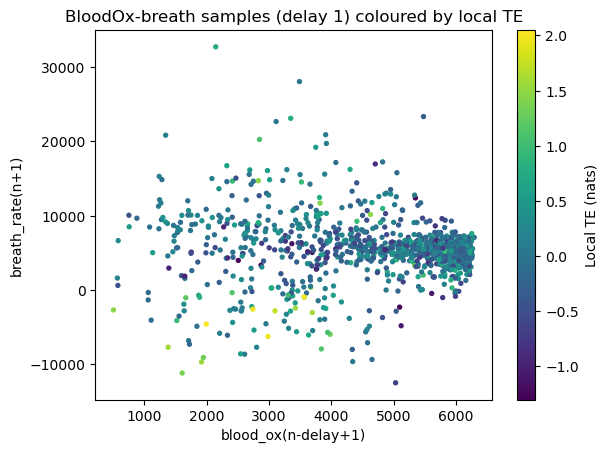

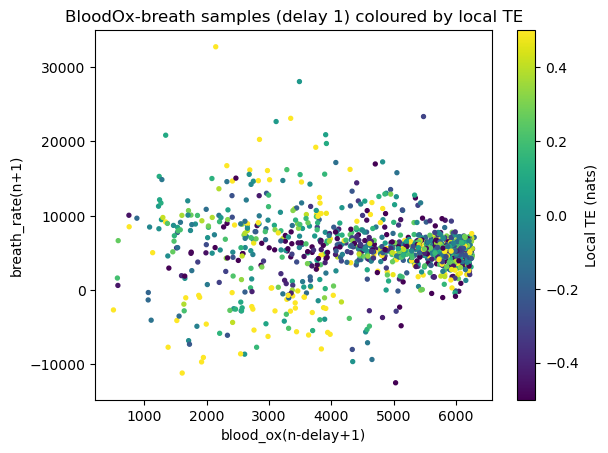

In [12]:
# Copy your heart->breath TE code and adapt it below:

# 0. Load/prepare the data:
dataRaw = readFloatsFile.readFloatsFile("/home/joseph/JIDT/infodynamics-dist-1.6.1/demos/data/SFI-heartRate_breathVol_bloodOx-extract.txt")
# As numpy array:
data = numpy.array(dataRaw)
source = JArray(JDouble, 1)(data[:,2].tolist())
destination = JArray(JDouble, 1)(data[:,1].tolist())

maxDelay = 20;
results = numpy.zeros(maxDelay)

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("k_HISTORY", "2")
calc.setProperty("l_HISTORY", "2")
calc.setProperty("l_TAU", "3")
for delay in range(1,maxDelay+1):
    calc.setProperty("DELAY", str(delay))
    calc.setProperty("DYN_CORR_EXCL", "21")
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(source, destination)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    results[delay-1] = result;
    # 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
    measDist = calc.computeSignificance(100)
    
    print("TE_Kraskov (KSG)(delay %d) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
        (delay, result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, 100))

plt.figure();
plt.scatter(range(1,maxDelay+1), results, marker='x', color='red');
plt.xlabel('delay (time units)');
plt.ylabel('TE (nats)');
plt.title('Blood ox. conc. to breath rate TE versus delay');

# Pull out the optimal delay (we know this to be 5, but this is how to do it automatically in code):
delay = numpy.argmax(results) + 1; # Need to add one to the index here
print('Optimal delay was %d' % delay)

calc.setProperty("DELAY", str(delay))
calc.setProperty("DYN_CORR_EXCL", "21")
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

# Compute the local TE values:
localTEs = calc.computeLocalOfPreviousObservations();

# First let's colour the transitions in breath rate with the TE values
plt.figure();
plt.scatter(destination[delay-1:-1], destination[delay:], c=localTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('breath_rate(n)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local TE (nats)');
plt.title('Breath samples coloured by local TE from blood ox.');

# Make a second plot where we highlight the values outside the central range:
plt.figure();
plt.scatter(destination[delay-1:-1], destination[delay:], c=localTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('breath_rate(n)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local TE (nats)');
plt.title('Breath samples coloured by local TE from blood ox.');
plt.clim(-0.5,0.5); # Can use this to highlight values out of the central range

# Next let's make a scatter plot showing the blood ox. values:
plt.figure();
plt.scatter(source[:-delay], destination[delay:], c=localTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('blood_ox(n-delay+1)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local TE (nats)');
plt.title('BloodOx-breath samples (delay %d) coloured by local TE' % delay);

# Make a second plot where we highlight the values outside the central range:
plt.figure();
plt.scatter(source[:-delay], destination[delay:], c=localTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('blood_ox(n-delay+1)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local TE (nats)');
plt.title('BloodOx-breath samples (delay %d) coloured by local TE' % delay);
plt.clim(-0.5,0.5); # Can use this to highlight values out of the central range

5. If you didn't automate setting the `delay` variable to the optimal value, then go back to the code and change the `delay` variable after the loop to the optimal value; and then run the code again. Now, examine the scatter plots coloured by local TE values to see which parts of the dynamics are well explained by the blood oxygen concentration. (You will certainly find it useful to alter the colorbar limits as before, `plt.clim(-0.5,0.5);`). Are these the same or different than we saw for the heart rate? What further insights does this give you about how conditioning on blood oxygenation may change the TE from heart rate to breath rate?

Sample solution plots are available on the tutorial webpage.

## D. Conditional transfer entropies

Now that we have determined two significant relationships from heart rate and blood oxygen concentration to breath rate, and all of their embedding parameters, let's examine conditional transfer entropies from each of them to the breath rate.
1. Open a new instance of the AutoAnalyser and select the Conditional Transfer Entropy.
2. Select the `Kraskov (KSG)` estimator, and the `SFI-heartRate_breathVol_bloodOx-extract.txt` data set as before.
3. Leave the source column at 0 (heart rate), destination column at 1 (breath rate) and conditional column at 2 (blood oxygen concentration).
4. Check the `Add stat. signif.?` button, as we wish to check the statistical significance of our measurements.
5. Set `DYN_CORR_EXCL` to 21 as above.
6. Set the embedding variables for the breath rate (`k_HISTORY` and `k_TAU`) and heart rate (`l_HISTORY` and `l_TAU`) to any non-default values that were determined for their pairwise TE above.
7. Set the `DELAY` to the optimised value determined for the pairwise TE between heart rate and breath rate above.
8. Now set the embedding values for the blood oxygen concentration as the conditional:
    * Set `COND_EMBED_LENGTHS` to the value determined for `l_HISTORY` in the blood oxygen to breath rate analysis.
    * Set `COND_TAUS` to the value determined for `l_TAU` in the blood oxygen to breath rate analysis.
    * Set `COND_DELAYS` to the value determined for `delay` in the blood oxygen to breath rate analysis.
9. Now press `Generate code and Compute` and inspect the result. Is there a significant conditional TE here? What can you determine from that:
    * Would the heart rate be usefully added to a model of the dynamics of breath rate, if blood oxygenation was already included in the model? Is this what you expected from above? (In other words, does the heart rate add information that blood oxygen concentration does not alone -- and could we see clues about this from our investigations above?)
    * Does it mean there is or is not a directed relationship from the heart rate to breath rate alone?
    * What does it mean for how we would consider both sources? If you had to choose one source only in a model of the breath rate, which would it be and why? Would you use both sources? (Can you conclude fully on this without running another calculation?)
    * If the result was not (or had not been) significant, do you think the result might change if we had more data?
10. (_Optional challenge_) Can you investigate the local values of TE from heart rate to breath rate, conditioned on blood oxygenation, to see which effects persisted and which did not? You would take the code generated from the previous step, paste this into the code cell below, then copy and paste the code from the pairwise TE investigation earlier which generated the local TE values and then made the plots with them. You would want to compare the plots made here for conditional TE to those for pairwise TE before. You would find the `plt.clim(-0.5,0.5);` command useful as above.

CTE_Kraskov (KSG)(heart -> breath | bloodOx) = 0.0236 nats (null: -0.0020 +/- 0.0103 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)


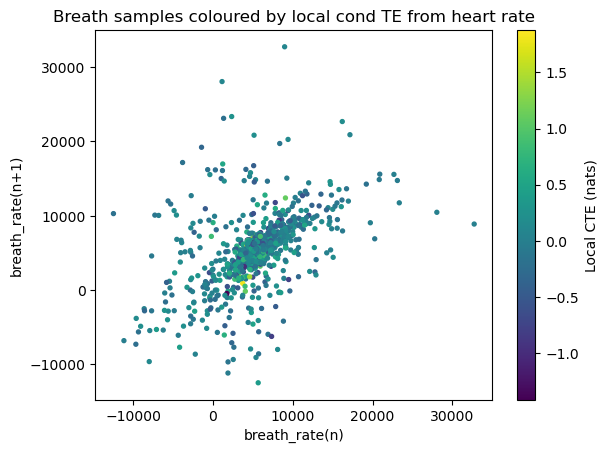

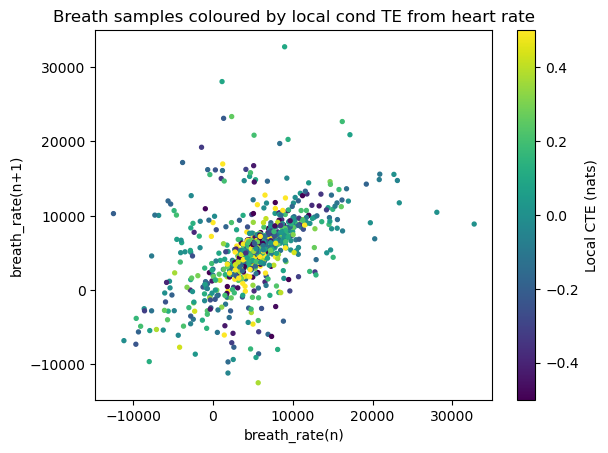

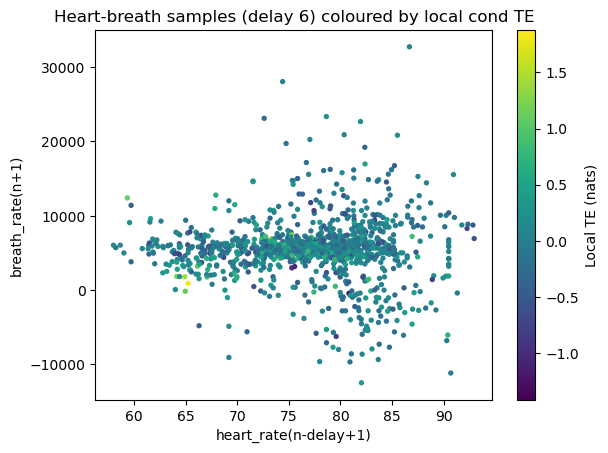

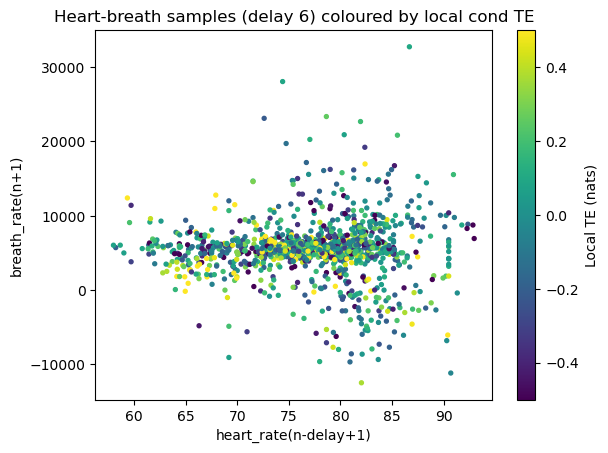

In [13]:
# Add code for the optional challenge task of plotting local conditional TE values:

# 0. Load/prepare the data:
dataRaw = readFloatsFile.readFloatsFile("/home/joseph/JIDT/infodynamics-dist-1.6.1/demos/data/SFI-heartRate_breathVol_bloodOx-extract.txt")
# As numpy array:
data = numpy.array(dataRaw)
source = JArray(JDouble, 1)(data[:,0].tolist())
destination = JArray(JDouble, 1)(data[:,1].tolist())
conditional = JArray(JDouble, 1)(data[:,2].tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").ConditionalTransferEntropyCalculatorKraskov
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("k_HISTORY", "2")
calc.setProperty("l_HISTORY", "2")
calc.setProperty("DELAY", "6")
calc.setProperty("COND_EMBED_LENGTHS", "2")
calc.setProperty("COND_TAUS", "3")
calc.setProperty("DYN_CORR_EXCL", "21")
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination, conditional)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()
# 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
measDist = calc.computeSignificance(100)

print("CTE_Kraskov (KSG)(heart -> breath | bloodOx) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, 100))

# Compute the local TE values:
localCondTEs = calc.computeLocalOfPreviousObservations();

# First let's colour the transitions in breath rate with the local conditional TE values
delay = int(calc.getProperty('DELAY')); # Instead of hard-coding this in case of changes, we'll work it out
plt.figure();
plt.scatter(destination[delay-1:-1], destination[delay:], c=localCondTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('breath_rate(n)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local CTE (nats)');
plt.title('Breath samples coloured by local cond TE from heart rate');

# Make a second plot where we highlight the values outside the central range:
plt.figure();
plt.scatter(destination[delay-1:-1], destination[delay:], c=localCondTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('breath_rate(n)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local CTE (nats)');
plt.title('Breath samples coloured by local cond TE from heart rate');
plt.clim(-0.5,0.5); # Can use this to highlight values out of the central range

# Next let's make a scatter plot showing the heart values:
plt.figure();
plt.scatter(source[:-delay], destination[delay:], c=localCondTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('heart_rate(n-delay+1)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local TE (nats)');
plt.title('Heart-breath samples (delay %d) coloured by local cond TE' % delay);

# Make a second plot where we highlight the values outside the central range:
plt.figure();
plt.scatter(source[:-delay], destination[delay:], c=localCondTEs[delay:], marker='o', facecolors='none', s=8);
plt.xlabel('heart_rate(n-delay+1)'); plt.ylabel('breath_rate(n+1)'); plt.colorbar(label='Local TE (nats)');
plt.title('Heart-breath samples (delay %d) coloured by local cond TE' % delay);
plt.clim(-0.5,0.5); # Can use this to highlight values out of the central range

11. Let's also check whether the blood oxygenation adds any information that the heart rate does not by computing TE from blood oxygenation conditioned on heart rate. Continuing in the AutoAnalyser with the values as currently set, now:
    * Swap the source and conditional column values
    * Swap the values of `l_HISTORY` and `COND_EMBED_LENGTHS`
    * Swap the values of `l_TAU` and `COND_TAUS`
    * Swap the values of `DELAY` and `COND_DELAYS`
12. Press `Generate code and Compute` - observe the answer - do we have a statistically significant result? What can we conclude about whether the blood oxygenation would be usefully added to a model of the dynamics of breath rate, given that heart rate was already included in the model?